# Approche Supervisée

In [140]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ast import literal_eval
import pickle

from pandarallel import pandarallel

pandarallel.initialize(progress_bar=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [141]:
data = pd.read_csv("data.csv", sep=';')
data.head()

Tags  \
0  ['algorithm', 'data-structures', 'tree', 'bina...   
1  ['c#', '.net', 'winforms', 'user-interface', '...   
2  ['html', 'css', 'html-table', 'internet-explor...   
3  ['windows', 'command-line', 'audio', 'batch-fi...   
4  ['android', 'android-listview', 'android-editt...   

                                        title_tokens  \
0  ['parent', 'vertex', 'perfect', 'binary', 'tree']   
1                       ['cursor', 'wait', 'cursor']   
2       ['html', 'table', 'break', 'line', 'hyphen']   
3     ['play', 'audio', 'file', 'window', 'command']   
4  ['edittext', 'listview', 'loses', 'focus', 'pr...   

                                       corpus_tokens  
0  ['parent', 'vertex', 'perfect', 'binary', 'tre...  
1  ['cursor', 'wait', 'cursor', 'display', 'wait'...  
2  ['html', 'table', 'break', 'line', 'table', 'c...  
3  ['play', 'audio', 'file', 'window', 'command',...  
4  ['edittext', 'listview', 'loses', 'focus', 'pr...

In [142]:
print("avant : ", type(data.loc[0, 'Tags']))
data['Tags'] = data['Tags'].apply(literal_eval)
data['corpus_tokens'] = data['corpus_tokens'].apply(literal_eval)
data['title_tokens'] = data['title_tokens'].apply(literal_eval)
print("après : ", type(data.loc[0, 'Tags']))

avant :  <class 'str'>
après :  <class 'list'>


In [143]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

vectorizer_1 = TfidfVectorizer(min_df=0.01)
vectorizer_2 = TfidfVectorizer(min_df=0.01)

# Join les tokens
data['title_tokens_joined'] = data['title_tokens'].apply(lambda x: ' '.join(x))
data['corpus_tokens_joined'] = data['corpus_tokens'].apply(lambda x: ' '.join(x))

# Split en train/test
X_train, X_test, y_train, y_test = train_test_split(data[['corpus_tokens', 'title_tokens', 'corpus_tokens_joined', 'title_tokens_joined']], data['Tags'], random_state=42, test_size=0.25)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# 1 Approche Fit sur Title et transform sur Corpus
X_train_matrix_title = vectorizer_1.fit(X_train['title_tokens_joined'])
X_train_matrix_corpus_1 = vectorizer_1.transform(X_train['corpus_tokens_joined'])
X_test_matrix_corpus_1 = vectorizer_1.transform(X_test['corpus_tokens_joined'])
# 2 Approche Fit transform sur Corpus
X_train_matrix_corpus = vectorizer_2.fit(X_train['corpus_tokens_joined'])
X_train_matrix_corpus_2 = vectorizer_2.transform(X_train['corpus_tokens_joined'])
X_test_matrix_corpus_2 = vectorizer_2.transform(X_test['corpus_tokens_joined'])

# BOW Approche 1
bag_of_words_corpus_train_1 = pd.DataFrame(X_train_matrix_corpus_1.toarray(), columns=vectorizer_1.get_feature_names_out(), index=X_train.index)
bag_of_words_corpus_test_1 = pd.DataFrame(X_test_matrix_corpus_1.toarray(), columns=vectorizer_1.get_feature_names_out(), index=X_test.index)
# BOW Approche 2
bag_of_words_corpus_train_2 = pd.DataFrame(X_train_matrix_corpus_2.toarray(), columns=vectorizer_2.get_feature_names_out(), index=X_train.index)
bag_of_words_corpus_test_2 = pd.DataFrame(X_test_matrix_corpus_2.toarray(), columns=vectorizer_2.get_feature_names_out(), index=X_test.index)

 ### Préparation de la target(Tags)

In [144]:
y_train.head(5)

0                    [linux, git, bash, shell, ubuntu]
1      [java, xml, datetime, jaxb, gregorian-calendar]
2    [php, apache, .htaccess, mod-rewrite, http-sta...
3    [c#, asp.net, asp.net-mvc, asp.net-mvc-3, asp....
4          [php, python, function, decorator, wrapper]
Name: Tags, dtype: object

In [145]:
train_tag_fq = y_train.explode().value_counts(ascending=False)

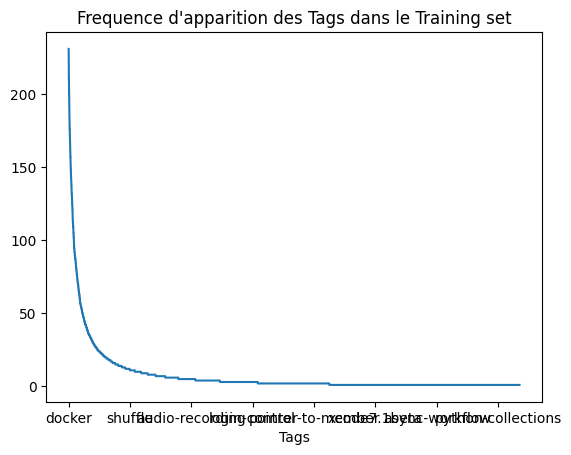

In [146]:
train_tag_fq[100:].plot()
plt.title("Frequence d'apparition des Tags dans le Training set")
plt.show()

Je ne garde que les 100 Tags les plus donné

In [147]:
train_tags_to_remove_100 = y_train.explode().value_counts(ascending=False)[100:]
train_tags_to_remove_10 = y_train.explode().value_counts(ascending=False)[10:]
train_tags_to_remove_100

Tags
docker                     231
user-interface             230
scala                      228
apache                     226
math                       219
                          ... 
wikitext                     1
asp.net-core-middleware      1
constantfolding              1
stripes                      1
google-photos                1
Name: count, Length: 14701, dtype: int64

In [148]:
def remove_element_from_list_in_list(serie, list_to_remove):
    """Supprime les éléments présents dans les listes d'une serie depuis une autre liste

    Args:
        serie (Series): Series contenant les liste cibles
        list_to_remove (list): Liste des éléments a supprimer
    """
    serie = serie.parallel_apply(lambda x: [x_el for x_el in x if x_el not in list_to_remove])
    return serie

Les Tags qui ne sont pas dans les 100 plus fréquents sont supprimés

In [149]:
y_train = remove_element_from_list_in_list(y_train, train_tags_to_remove_100.index.to_list())
y_train_10 = remove_element_from_list_in_list(y_train, train_tags_to_remove_10.index.to_list())

In [150]:
index_of_sentences_without_targets = y_train[y_train.str.len() == 0].index.to_list()
print('Il y a en conséquences ', len(index_of_sentences_without_targets), ' documents sans target. Elles sont donc à supprimer')

Il y a en conséquences  2253  documents sans target. Elles sont donc à supprimer


In [151]:
print('On passe de ', X_train.shape[0], ' documents')
X_train = X_train.drop(index=index_of_sentences_without_targets)
y_train = y_train.drop(index=index_of_sentences_without_targets)
y_train_10 = y_train_10.drop(index=index_of_sentences_without_targets)
bag_of_words_corpus_train_1 = bag_of_words_corpus_train_1.drop(index=index_of_sentences_without_targets, axis=0)
bag_of_words_corpus_train_2 = bag_of_words_corpus_train_2.drop(index=index_of_sentences_without_targets, axis=0)
print('à ', X_train.shape[0], ' documents')

On passe de  37470  documents
à  35217  documents


Tansformation Target

In [152]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
train_tags_binarized = mlb.fit_transform(y_train_10)
test_tags_binarized = mlb.transform(y_test)

c:\Users\vkubi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:895: UserWarning: unknown class(es) ['.a', '.class-file', '.htaccess', '.net-1.1', '.net-2.0', '.net-3.0', '.net-3.5', '.net-4.0', '.net-4.5', '.net-4.6.1', '.net-5', '.net-6.0', '.net-assembly', '.net-core', '.net-core-2.0', '.net-core-3.0', '.net-core-rc2', '.net-framework-version', '.net-standard', '.net-standard-2.1', '.obj', '.profile', '16-bit', '2d', '2d-games', '3-tier', '32-bit', '32bit-64bit', '3d', '3d-reconstruction', '3d-secure', '4g', '64-bit', '7zip', 'a-star', 'a2dp', 'aac', 'aapt', 'aapt2', 'aar', 'ab-testing', 'abap', 'abbr', 'abi', 'abort', 'absolute-path', 'abstract', 'abstract-class', 'abstract-data-type', 'abstract-factory', 'abstract-syntax-tree', 'abstraction', 'accelerate-framework', 'accelerometer', 'access-control', 'access-denied', 'access-levels', 'access-modifiers', 'access-specifier', 'access-token', 'accesscontrolexception', 'accessibility', 'accessib

In [153]:
pickle.dump(mlb, open('mlb.pkl', 'wb'))

## Tests des algorithmes

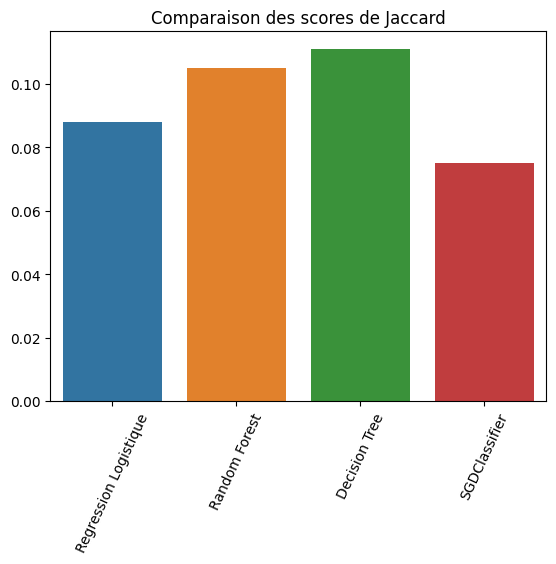

In [154]:
sns.barplot(y=[0.088, 0.105, 0.111, 0.075], x=["Regression Logistique", "Random Forest", "Decision Tree", "SGDClassifier"])
plt.xticks(rotation=65)
plt.title("Comparaison des scores de Jaccard")
plt.show()

In [155]:
from sklearn.multiclass import OneVsRestClassifier

### Regression Logistique

In [156]:
from sklearn.linear_model import LogisticRegression
print(bag_of_words_corpus_train_1.shape)
print(train_tags_binarized.shape)
# Entrainement
classifier_logistic = OneVsRestClassifier(estimator=LogisticRegression(), n_jobs=-1)
classifier_logistic.fit(bag_of_words_corpus_train_1, train_tags_binarized)
# Prediction
y_pred_logistic = classifier_logistic.predict(bag_of_words_corpus_test_1)
proba_logistic = classifier_logistic.predict_proba(bag_of_words_corpus_test_1)
proba_logistic

(35217, 59)
(35217, 10)


array([[0.05957351, 0.0382988 , 0.10013905, ..., 0.07865536, 0.02239385,
        0.06966334],
       [0.05061754, 0.01939352, 0.14626049, ..., 0.12092853, 0.02075085,
        0.07276263],
       [0.05957351, 0.0382988 , 0.10013905, ..., 0.07865536, 0.02239385,
        0.06966334],
       ...,
       [0.00413287, 0.01358548, 0.0091065 , ..., 0.05400548, 0.00780953,
        0.00702962],
       [0.05957351, 0.0382988 , 0.10013905, ..., 0.07865536, 0.02239385,
        0.06966334],
       [0.08764806, 0.01300826, 0.19166842, ..., 0.08849336, 0.03765384,
        0.09303972]])

### Random Forest Classifier

In [157]:
from sklearn.ensemble import RandomForestClassifier

# # Entrainement
# classifier_forest = OneVsRestClassifier(estimator=RandomForestClassifier())
# classifier_forest.fit(bag_of_words_corpus_train_1, train_tags_binarized)
# # Prediction
# y_pred_forest = classifier_forest.predict(bag_of_words_corpus_test_1)
# proba_forest = classifier_forest.predict_proba(bag_of_words_corpus_test_1)
# proba_forest

### Decision Tree

In [158]:
from sklearn.tree import DecisionTreeClassifier

# Entrainement
classifier_tree = OneVsRestClassifier(DecisionTreeClassifier())
classifier_tree.fit(bag_of_words_corpus_train_1, train_tags_binarized)
# Prediction
y_pred_tree = classifier_tree.predict(bag_of_words_corpus_test_1)
proba_tree = classifier_tree.predict_proba(bag_of_words_corpus_test_1)
proba_tree

array([[0.07396928, 0.04971706, 0.12489895, ..., 0.09256265, 0.02263541,
        0.07962813],
       [0.        , 0.        , 0.        , ..., 0.25      , 0.        ,
        0.        ],
       [0.07396928, 0.04971706, 0.12489895, ..., 0.09256265, 0.02263541,
        0.07962813],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.07396928, 0.04971706, 0.12489895, ..., 0.09256265, 0.02263541,
        0.07962813],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

### SGDClassifier

In [159]:
from sklearn.linear_model import SGDClassifier

# Entrainement
classifier_sgd = OneVsRestClassifier(SGDClassifier())
classifier_sgd.fit(bag_of_words_corpus_train_1, train_tags_binarized)
# Prediction
y_pred_sgd = classifier_sgd.predict(bag_of_words_corpus_test_1)
y_pred_sgd

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

### Comparaison résultats

Score de Jaccard :<br>
-> micro : Utilisé quand les classes sont très déséquilibrées et qu'on souhaite accorder une importance égale à chaque<br>
-> macro : Utilisé lorsqu'on souhaite accorder un importance égale à chaque, indépendamment de la distribution ou taille des classes<br>
-> weighted : Pareil macro sauf qu'on souhaite prendre en cimote la taille des ensembles de références dans le calcul du score global.

In [160]:
from sklearn.metrics import jaccard_score

print('Score de la Regression Logistique : ', jaccard_score(y_true=test_tags_binarized, y_pred=y_pred_logistic, average='macro'))
# print('Score de Random Random Forest : ', jaccard_score(y_true=test_tags_binarized, y_pred=y_pred_forest, average='macro'))
print('Score de Decision Tree : ', jaccard_score(y_true=test_tags_binarized, y_pred=y_pred_tree, average='macro'))
print('Score de SGD : ', jaccard_score(y_true=test_tags_binarized, y_pred=y_pred_sgd, average='macro'))

Score de la Regression Logistique :  0.26905494464660784
Score de Decision Tree :  0.2693978646631911
Score de SGD :  0.2792118034243654


---
# Approche non supervisée

## LDA (Latent Dirichlet Allocation)

In [161]:
import gensim
from gensim import corpora, models
from gensim.matutils import Sparse2Corpus

# Creation du dictionnaire
train_id2word = corpora.Dictionary(documents=X_train['corpus_tokens'])
test_id2word = corpora.Dictionary(documents=X_test['corpus_tokens'])

# Tentative conversion TF Sklearn pour gensim
# train_corpus = Sparse2Corpus(sparse=X_train_matrix_corpus_1, documents_columns=False)
# test_corpus = Sparse2Corpus(sparse=X_test_matrix_corpus_1, documents_columns=False)
# Creation Tf
train_corpus = [train_id2word.doc2bow(text) for text in X_train['corpus_tokens']]
test_corpus = [test_id2word.doc2bow(text) for text in X_test['corpus_tokens']]

In [162]:
lda = gensim.models.ldamulticore.LdaMulticore(corpus=train_corpus,
                                      id2word=train_id2word,
                                      num_topics=11,
                                      random_state=42,
                                      chunksize=100,
                                      passes=10)


In [163]:
from pprint import pprint

pprint(lda.print_topics())

[(0,
  '0.029*"error" + 0.023*"file" + 0.020*"project" + 0.013*"version" + '
  '0.013*"app" + 0.012*"build" + 0.011*"studio" + 0.011*"application" + '
  '0.010*"server" + 0.009*"visual"'),
 (1,
  '0.015*"java" + 0.014*"application" + 0.014*"memory" + 0.013*"android" + '
  '0.013*"code" + 0.012*"time" + 0.011*"window" + 0.008*"bit" + 0.007*"c" + '
  '0.007*"program"'),
 (2,
  '0.037*"class" + 0.018*"file" + 0.014*"project" + 0.013*"library" + '
  '0.011*"framework" + 0.009*"application" + 0.008*"create" + 0.008*"c" + '
  '0.008*"key" + 0.007*"code"'),
 (3,
  '0.039*"c" + 0.021*"object" + 0.019*"string" + 0.018*"code" + '
  '0.017*"function" + 0.017*"type" + 0.016*"method" + 0.015*"class" + '
  '0.011*"java" + 0.009*"question"'),
 (4,
  '0.022*"table" + 0.020*"data" + 0.018*"database" + 0.016*"sql" + '
  '0.015*"list" + 0.013*"query" + 0.013*"column" + 0.012*"array" + '
  '0.010*"string" + 0.010*"row"'),
 (5,
  '0.023*"model" + 0.021*"django" + 0.020*"variable" + 0.019*"test" + '
  '0.01

In [164]:
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, train_corpus, train_id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.134774 -0.146735       1        1  15.988727
10     0.137318  0.027169       2        1  13.923401
4     -0.118718  0.055625       3        1  11.398304
3     -0.140814  0.006450       4        1  11.257393
1     -0.027847 -0.093804       5        1  10.307747
9      0.086720  0.209832       6        1   9.236531
2      0.029418 -0.102927       7        1   6.860547
8      0.150490  0.017327       8        1   6.770848
7     -0.097165  0.103152       9        1   5.524611
6     -0.014394  0.020381      10        1   4.624642
5     -0.139783 -0.096470      11        1   4.107248, topic_info=         Term          Freq         Total Category  logprob  loglift
52       file  12236.000000  12236.000000  Default  30.0000  30.0000
108    python   3899.000000   3899.000000  Default  29.0000  29.0000
262     image   4830.000000   4830.000000  Default  28.0000  28.0000
155     class   5750.000000   5750.000000  Default  27.0000  27.0000
65          c   8352.000000   8352.000000  Default  26.0000  26.0000
..        ...           ...           ...      ...      ...      ...
362      rail    203.009651   1139.330740  Topic11  -5.4440   1.4675
33     object    254.224176   4914.176495  Topic11  -5.2190   0.2308
907     write    214.416592   1801.543603  Topic11  -5.3893   1.0639
146  question    232.206547   5261.926130  Topic11  -5.3096   0.0718
6    function    202.223546   4718.538627  Topic11  -5.4479   0.0425

[922 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
6838       4  0.015941      123
6838       8  0.924572      123
6838      11  0.057387      123
4410      11  0.992896     1234
17373      8  0.958347      160
...      ...       ...      ...
777        5  0.054976     zone
777        6  0.006872     zone
777        9  0.006872     zone
6656       4  0.985127  zooming
5484      11  0.980421      zsh

[3968 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 11, 5, 4, 2, 10, 3, 9, 8, 7, 6])

In [165]:
from gensim.models import CoherenceModel

cm = CoherenceModel(model=lda, texts=X_train['corpus_tokens'], dictionary=train_id2word, coherence='c_v')
coherence = cm.get_coherence()
print('Coherence Score: ', coherence)

Coherence Score:  0.4336848091546642


### Optimisation des Hyperparamètres

In [166]:
def compute_coherence_value(corpus, dictionary, n_topics: int, alpha, base_text) -> float:
    """Calcule le score de Cohérence d'un modèle LDA

    Args:
        corpus : Corpus de texte
        dictionary : Dictionnaire de mots utilisé dans le Corpus et frequence d'utilisation
        n_topics : Nombre de topics à trouver
        alpha : Densité des topics au niveau du corpus
        base_text : Texte de Base traité
    
    Returns:
        float: Le score de cohérence
    """
    lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                      id2word=dictionary,
                                      num_topics=n_topics,
                                      random_state=42,
                                      chunksize=100,
                                      passes=10,
                                      alpha=alpha)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=base_text, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [167]:
# Recherche dans un premier temps du nombre de topic optimal
# topic_range = range(2, 15, 1)
# coherences_values = []
# for i in topic_range:
#     coherences_values.append(compute_coherence_value(corpus=train_corpus, dictionary=train_id2word, n_topics=i, alpha='symmetric', base_text=data['corpus_tokens']))
    
# sns.lineplot(x=topic_range, y=coherences_values)
# plt.title("Score de cohérence en fonction du nombre de Topic")
# plt.show()

In [168]:
def create_topic_word_matrix(n_topics, lda_model):
    """Créer la matrice Topic - Mot

    Args:
        n_topics (int): Nombre de topics
        lda_model : Modèle LDA entrainé

    Returns:
        La matrice Topic - Mot
    """
    from collections import OrderedDict
    data_lda = {i: OrderedDict(lda_model.show_topic(i,n_topics)) for i in range(n_topics)}
    matrix = pd.DataFrame(data_lda)
    matrix = matrix.fillna(0).T

    return matrix

In [169]:
def create_question_topic_matrix(n_topics, corpus, lda_model):
    """Créer la Matrice Question - Topic

    Args:
        n_topics (int): Nombre de Topics attendu
        corpus : Corpus de texte
        lda_model : Modele LDA déjà entrainé
    
    Returns:
        Matrice ()
    """
    # Créer d'abord les topics en colonne
    matrix = pd.DataFrame(columns=np.arange(n_topics-1))
    # Récupère les probabilitées de chaque mots
    docTopicProbMat = list(lda_model[corpus])
    
    # Stocke pour chaque document les probabilités d'appartenance à un topic
    for i in range(len(docTopicProbMat)):
        for j in range(len(docTopicProbMat[i])):
            matrix.loc[i, docTopicProbMat[i][j][0]] = docTopicProbMat[i][j][1]    
    matrix = matrix.fillna(0)
    return matrix

In [170]:
def create_question_word_matrix(matrix_question_topic, matrix_topic_word):
    """ Créer la matrice question - mot à partir des deux autres matrices

    Args:
        matrix_question_topic : Matrice question - topic
        matrix_topic_word : Matrice topic - mot
    """
    return matrix_question_topic @ matrix_topic_word

La matrice de question - word sur jeu de TEST

In [171]:
test_matrix_question_topic = create_question_topic_matrix(n_topics=11, corpus=test_corpus, lda_model=lda)
test_matrix_topic_word = create_topic_word_matrix(n_topics=11, lda_model=lda)
test_matrix_question_word = create_question_word_matrix(matrix_question_topic=test_matrix_question_topic, matrix_topic_word=test_matrix_topic_word)

In [172]:
test_matrix_question_word

error      file   project   version       app     build    studio  \
0      0.000669  0.010895  0.007499  0.000237  0.000665  0.000216  0.000206   
1      0.001649  0.004527  0.002141  0.000000  0.000000  0.000000  0.000000   
2      0.001811  0.001853  0.000000  0.000000  0.000000  0.000000  0.000000   
3      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4      0.000000  0.015843  0.005258  0.000000  0.003090  0.000000  0.000000   
...         ...       ...       ...       ...       ...       ...       ...   
12486  0.000000  0.000000  0.000000  0.000000  0.000655  0.000000  0.000000   
12487  0.000000  0.019366  0.000000  0.000000  0.004284  0.000000  0.000000   
12488  0.006249  0.009467  0.004463  0.002850  0.003709  0.002599  0.002470   
12489  0.007261  0.008233  0.005644  0.002644  0.002547  0.002411  0.002291   
12490  0.006798  0.020998  0.004855  0.003100  0.006402  0.002827  0.002687   

       application    server    visual  ...    screen       bar      font  \
0         0.005376  0.000410  0.000160  ...  0.000158  0.000152  0.000150   
1         0.001421  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
2         0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
3         0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
4         0.004390  0.001051  0.000000  ...  0.000000  0.000000  0.000000   
...            ...       ...       ...  ...       ...       ...       ...   
12486     0.000522  0.000610  0.000000  ...  0.001326  0.001268  0.001253   
12487     0.002793  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
12488     0.002364  0.002186  0.001922  ...  0.000000  0.000000  0.000000   
12489     0.003191  0.002028  0.001783  ...  0.001588  0.001518  0.001500   
12490     0.002572  0.002378  0.002091  ...  0.000000  0.000000  0.000000   

           user   request       web    client       api   service    jquery  
0      0.000454  0.000296  0.000224  0.000197  0.000193  0.000184  0.000159  
1      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
2      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
3      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
4      0.002093  0.001365  0.001031  0.000908  0.000892  0.000847  0.000733  
...         ...       ...       ...       ...       ...       ...       ...  
12486  0.001216  0.000793  0.000599  0.000527  0.000518  0.000492  0.000426  
12487  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
12488  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
12489  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
12490  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  

[12491 rows x 89 columns]

### Tentative Filtrage des valeurs

In [173]:
test_matrix_question_word_filtered = test_matrix_question_word.copy(deep=True)
test_matrix_question_word_filtered[test_matrix_question_word_filtered < 0.008] = np.NaN

In [174]:
print('Prédiction :', test_matrix_question_word_filtered.iloc[13].dropna().index.to_list())
print('Tags réels : ', y_test.iloc[13])

Prédiction : ['error', 'file', 'project', 'code', 'class']
Tags réels :  ['android', 'android-layout', 'android-emulator', 'android-intent', 'android-widget']


### Liste des 5 mots les plus probables pour chaque lignes

In [175]:
def top5_columns(row):
    """Avec une ligne donnée retourne le TOP 5 des colonnes ayant la plus grande valeur

    Args:
        row : Ligne d'un DataFrame

    Returns:
        Un tableau contenant la liste des 5 colonnes
    """
    sorted_row = row.sort_values(ascending=False)
    top5 = sorted_row[:5]
    return top5.index.tolist()

In [176]:
top5_columns_per_row  = test_matrix_question_word.apply(top5_columns, axis=1)
top5_columns_per_row

0           [class, file, code, project, model]
1            [thread, data, model, code, table]
2           [c, code, object, string, function]
3           [c, object, string, code, function]
4        [file, class, image, project, library]
                          ...                  
12486      [python, code, image, model, django]
12487       [file, image, python, code, spring]
12488           [c, code, object, string, file]
12489             [c, code, file, class, error]
12490         [file, image, error, app, spring]
Length: 12491, dtype: object

### Taux de couverture

In [177]:
def compute_coverage_rate(predicted_tags, true_tags):
    if len(predicted_tags) != len(true_tags):
        raise ValueError("Le nombre de ligne de tags prédit et réels doivent être de la même taille.")
    
    coverage_count = 0
    for i in range(len(predicted_tags)):
        is_prediction_true = np.any(np.isin(predicted_tags[i], true_tags[i]))
        if is_prediction_true:
            coverage_count += 1
    
    coverage_rate = (coverage_count / len(predicted_tags)) * 100
    print("Taux de couverture: ", round(coverage_rate, 2), "%")
compute_coverage_rate(predicted_tags=top5_columns_per_row, true_tags=y_test)

Taux de couverture:  8.04 %


## Word Embedding

### Word2Vec

In [178]:
import multiprocessing
from gensim.models import Word2Vec
from random import sample

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

In [179]:
max_len=18
w2v_size = 100

# Approche 1 Train sur title transform sur text
# sg=0 -> CBOW | sg=1 -> Skip-gram ||| cbow prédit le mot cible en fonction du contexte - skip-gram prédit prédit le contexte (mots voisins) en fonction de la cible
model_wv = gensim.models.Word2Vec(window=5,
                                  min_count=1, 
                                  vector_size=w2v_size,
                                  workers=multiprocessing.cpu_count(),
                                  seed=42)
model_wv.build_vocab(X_train['title_tokens'])
model_wv.train(X_train['title_tokens'], total_examples=model_wv.corpus_count, epochs=100)
wv_vectors = model_wv.wv
wv_words = wv_vectors.index_to_key
print("Vocabulary size: %i" % len(wv_words))
print("Entrainement Word2Vec terminé !")

Vocabulary size: 13152
Entrainement Word2Vec terminé !


In [180]:
# Préparation des sentences (tokenization)

print("Entrainement Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['title_tokens'])
x_sentences = pad_sequences(tokenizer.texts_to_sequences(X_train['corpus_tokens']),
                                                     maxlen=max_len,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Entrainement Tokenizer ...
Number of unique words: 13153


In [181]:
print("Create Embedding matrix ...")
w2v_size = 100
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in wv_words:
        j +=1
        embedding_vector = wv_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = wv_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (13153, 100)


In [182]:
# Création du modèle

input=Input(shape=(len(x_sentences),max_len),dtype='float64')
word_input=Input(shape=(max_len,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=max_len)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 18)]              0         
                                                                 
 embedding_4 (Embedding)     (None, 18, 100)           1315300   
                                                                 
 global_average_pooling1d_4   (None, 100)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
Total params: 1,315,300
Trainable params: 1,315,300
Non-trainable params: 0
_________________________________________________________________


In [183]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

1101/1101 [==============================] - 1s 887us/step


(35217, 100)

### BERT

In [113]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import os, time, transformers
from transformers import *

os.environ["TF_KERAS"]='1'

c:\Users\vkubi\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\vkubi\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(


In [114]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

In [ ]:
max_length = 64
batch_size = 25
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = X_train['title_tokens'].apply(lambda x: ' '.join(x)).to_list()

In [ ]:
# Création des features
# batch size 25 == 11h
# batch size 10 == 1h30 je crois

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, b_size=10, mode='HF')
features_bert

### USE

In [184]:
def feature_USE_fct(sentences, b_size):
    batch_size = b_size
    time1 = time.time()
    features = []
    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [185]:
import tensorflow_hub as hub
sentences = X_train['corpus_tokens'].apply(lambda x: ' '.join(x)).to_list()
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
batch_size = 25
features_USE = feature_USE_fct(sentences, batch_size)

## Utilisation du word embedding de Word2Vec/BERT/USE

### USE

In [188]:
from sklearn.tree import DecisionTreeClassifier

# Entrainement
classifier_tree_use = OneVsRestClassifier(DecisionTreeClassifier())
classifier_tree_use.fit(features_USE, train_tags_binarized[:-17])

OneVsRestClassifier(estimator=DecisionTreeClassifier())

In [ ]:
# Préparation des features
X_test_features_use = feature_USE_fct(sentences=X_test['corpus_tokens'].apply(lambda x: ' '.join(x)).to_list(), b_size=3)
# Prédiction
y_pred_tree_use = classifier_tree_use.predict(X_test_features_use)
y_pred_tree_use_final = mlb.inverse_transform(y_pred_tree_use)
print('Score de Decision Tree avec USE : ', jaccard_score(y_true=test_tags_binarized, y_pred=y_pred_tree_use, average='macro'))

In [196]:
X_test['corpus_tokens'].apply(lambda x: ' '.join(x)).to_list()

['c preprocessor iso 8601',
 'c read write multiline textbox simple program function read multiline textbox press button code automaticaly textbox2 ect plz code _',
 'sigalrm multithread process linux c exact idea multithreaded program',
 'access kibana amazon elasticsearch service created amazon elasticsearch service populated data logstash installed ec2 instance amazon console link access kibana access policy domain modify access policy access kibana link',
 'azure devops angular environment commit master branch build pipeline generate artifact based build prod artifact production configuration project artifact deployed production environment environment code environment dev production environment prod achieve',
 'await return result http request multiple request serially assume function',
 'android file exists sensitive created folder sdcard dd check folder',
 'configuration failed initialize exceptionin winform app add usersetting error occuring appsettings setting exeption thrown 

In [195]:
classifier_tree_use.predict(X_test_features_use[:10])

array([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])

### BERT

In [129]:
# Entrainement
classifier_tree_bert = OneVsRestClassifier(DecisionTreeClassifier())
classifier_tree_bert.fit(features_bert, train_tags_binarized[:-5])

OneVsRestClassifier(estimator=DecisionTreeClassifier())

In [ ]:
# Préparation features
X_test_features_bert, void_thing = feature_BERT_fct(model=TFAutoModel.from_pretrained(model_type), 
                                                    model_type='bert-base-uncased', 
                                                    max_length=64, 
                                                    sentences=X_test['corpus_tokens'].apply(lambda x: ' '.join(x)).to_list(), 
                                                    b_size=3, 
                                                    mode='HF')
# Prédiction
y_pred_tree_bert = classifier_tree_bert.predict(X_test_features_bert)


In [131]:
print('Score de Decision Tree avec BERT : ', jaccard_score(y_true=test_tags_binarized, y_pred=y_pred_tree_bert, average='macro'))

Score de Decision Tree avec BERT :  0.08409472935823573


### Word2Vec

In [132]:
# Initialisation classifier
classifier_tree_wv = OneVsRestClassifier(DecisionTreeClassifier())
# Creation feature test
X_sentences_test = pad_sequences(tokenizer.texts_to_sequences(X_test['corpus_tokens']),
                                                     maxlen=max_len,
                                                     padding='post') 
# entrainement
classifier_tree_wv.fit(x_sentences, train_tags_binarized)
# Prédiction
y_pred_tree_wv = classifier_tree_wv.predict(X_sentences_test)
print('Score de Decision Tree avec Word2Vec : ', jaccard_score(y_true=test_tags_binarized, y_pred=y_pred_tree_wv, average='macro'))

Score de Decision Tree avec Word2Vec :  0.10513002145411424


## Enregistrement du modèle pour API

In [191]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

stop_words_df = pd.read_csv("stopwords-en.csv", sep=',', )
stop_words = stop_words_df.columns.to_list()

In [192]:
pickle.dump(classifier_tree_use, open('classifier_use.pkl', 'wb'))